## Vowel classifier version 0.1

Following the guide of https://www.youtube.com/watch?v=ZLIPkmmDJAc&ab_channel=NicholasRenotte 


In [5]:
!pip install tensorflow tensorflow-gpu tensorflow-io matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 6.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 6.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 21.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 693.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 KB 419.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 36.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 12.3 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 33.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 KB 1.0 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 KB 2.4 MB/s eta 0

In [9]:
# Import required modules
import subprocess
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import zipfile

### Build dataloading function

In [7]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels = 1)
    # Remove trailing axis
    wav = tf.squeeze(wav, axis =-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000Hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

### Plot wave
Here is an example of a plotted wave made by the function we just wrote

In [ ]:
# How to plot a single sound file? Check in video

In [8]:
wave = load_wav_16k_mono(single_a)
plt.plot(wave)
#plt.plot(nwave)
print(type(wave)) # Show what type the wave is
plt.show()

NameError: name 'single_a' is not defined

### Unzip files

In [250]:
zip_file = os.path.join('vowels','16bit_data_2.zip')
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall('vowels')
        print("Extracted all")
except:
    print("Invalid file")

Extracted all


### Create tensorflow dataset

In [10]:
# Define file paths for the two folders with either front or back vowels
FRONT =  os.path.join('vowels', '16bit_data', 'front') 
BACK =  os.path.join('vowels', '16bit_data', 'back') 


In [11]:
FRONT, BACK

('vowels/16bit_data/front', 'vowels/16bit_data/back')

In [12]:
# Slashes are regular slashes, not backslashes as in the guide
front = tf.data.Dataset.list_files(FRONT+'/*.wav')
back = tf.data.Dataset.list_files(BACK+'/*.wav')

In [13]:
back.as_numpy_iterator().next()

b'vowels/16bit_data/back/f07_iso_05.wav'

In [33]:
# These are the file names in the folder 'front'
os.listdir(os.path.join('vowels','16bit_data','front'))[:10]

['f04_short_06.wav',
 'f02_06.wav',
 'f12_01.wav',
 'f00_01.wav',
 'f07_long_06.wav',
 'f06_iso_01.wav',
 'f07_iso_01.wav',
 'f05_iso_01.wav',
 'm05_01.wav',
 'f04_iso_01.wav']

#### Add labels and combine positive and negative samples

Here, all the files that are front vowels have gotten a 1 attached to them, all the back vowel-files have gotten a 0.

In [15]:
front_lab = tf.data.Dataset.zip((front, tf.data.Dataset.from_tensor_slices(tf.ones(len(front)))))
back_lab = tf.data.Dataset.zip((back, tf.data.Dataset.from_tensor_slices(tf.zeros(len(back)))))
data = front_lab.concatenate(back_lab)
print(data)

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [16]:
len(data)

113

In [18]:
# Look through the data with this command. It shuffles the data and shows a random one, so you'll find both front and negatives here
data.shuffle(10000).as_numpy_iterator().next()


(b'vowels/16bit_data/back/f05_iso_05.wav', 0.0)

### Determine average length of the vowel recordings

In [29]:
lengths = []
for file in os.listdir(FRONT):
    tensor_wave = load_wav_16k_mono(os.path.join('vowels','16bit_data','front',file))
    lengths.append(len(tensor_wave))    
for file in os.listdir(BACK):
    tensor_wave = load_wav_16k_mono(os.path.join('vowels','16bit_data','back',file))
    lengths.append(len(tensor_wave))
print(lengths)

[2593, 2847, 3475, 2958, 3162, 5794, 7619, 11848, 5327, 12707, 4690, 3302, 5529, 3306, 5994, 2708, 8876, 3832, 8283, 28814, 11320, 6939, 1942, 4827, 5190, 4905, 6479, 5348, 2726, 2856, 8791, 2777, 5844, 6345, 7664, 8583, 7555, 3032, 4563, 4294, 5618, 5992, 2777, 8063, 3767, 7567, 4345, 9083, 5609, 3198, 4059, 5302, 3768, 3038, 8894, 3114, 5406, 8583, 6901, 5400, 9610, 13823, 13301, 6082, 6250, 6431, 4364, 3886, 5594, 3701, 5046, 7378, 3266, 3012, 11899, 2515, 3248, 12689, 4910, 8388, 5858, 3376, 6718, 4868, 12425, 2812, 2261, 3957, 4437, 3013, 2871, 3045, 10355, 4664, 12381, 3699, 15604, 3861, 16152, 5359, 2193, 8377, 4763, 4888, 8596, 11044, 3693, 4542, 11593, 5716, 11888, 3347, 10037]


In [30]:
short_lengths = []
for length in lengths:
    if length > 10000:
        pass
    
    else:
        short_lengths.append(length)
print(short_lengths)                        

[2593, 2847, 3475, 2958, 3162, 5794, 7619, 5327, 4690, 3302, 5529, 3306, 5994, 2708, 8876, 3832, 8283, 6939, 1942, 4827, 5190, 4905, 6479, 5348, 2726, 2856, 8791, 2777, 5844, 6345, 7664, 8583, 7555, 3032, 4563, 4294, 5618, 5992, 2777, 8063, 3767, 7567, 4345, 9083, 5609, 3198, 4059, 5302, 3768, 3038, 8894, 3114, 5406, 8583, 6901, 5400, 9610, 6082, 6250, 6431, 4364, 3886, 5594, 3701, 5046, 7378, 3266, 3012, 2515, 3248, 4910, 8388, 5858, 3376, 6718, 4868, 2812, 2261, 3957, 4437, 3013, 2871, 3045, 4664, 3699, 3861, 5359, 2193, 8377, 4763, 4888, 8596, 3693, 4542, 5716, 3347]


### Calculate means, min, max from the short_lengths

This is done in order to find a mean length that is not influenced by the outliers. 

The soundfiles will be trimmed to fit this mean length in the function 

In [404]:
# Find mean lenghth
tf.math.reduce_mean(short_lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=5195>

In [393]:
6091/16000   # this is the mean divided by hZ to convert to seconds (find out how this is actually calculated)

0.3806875

In [394]:
# Find min lenghth

tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=1942>

In [396]:
# Max length
tf.math.reduce_median(lengths)

AttributeError: module 'tensorflow._api.v2.math' has no attribute 'reduce_median'

In [405]:
tf.math.reduce_max(short_lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=9083>

### Build preprocessing function to convert to spectrogram

#### 5.1 Build preprocessing function

In [406]:
def preprocess(file_path, label):
    # Load the file with load_wav_16k_mono function
    wav = load_wav_16k_mono(filepath)
    # Take only the first 48000 steps
    wav = wav[:6000]
    # If the wav-file is shorter than 48000, pad it with zeros (add zeros at the start of the file)
    zero_padding = tf.zeros([6000]-tf.shape(wav),dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    # Create spectrogram with the short form fourier transform (.stft)
    spectrogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)
    # Convert it into absolute values (no negative numbers)
    spectrogram = tf.abs(spectrogram)
    spectrogram= tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label
    

#### 5.2 Test out the function and vizualize the spectrogram 

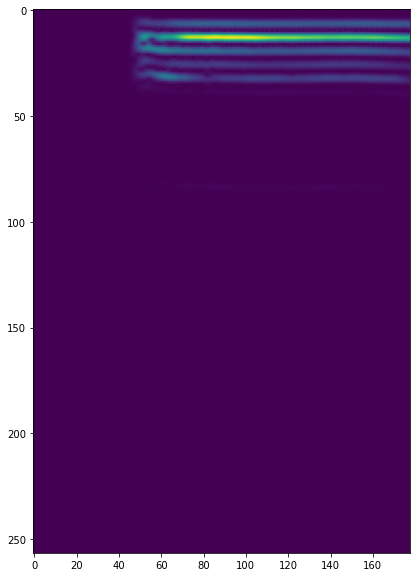

In [407]:
# Here, a random spectrogram from the negatives is chosen. 
# Substitue 'negatives' with 'positives' to see a capuchin spectrogram
filepath, label = alfa.shuffle(buffer_size = 10000).as_numpy_iterator().next()
spectogram, label = preprocess(filepath, label)
plt.figure(figsize=(15,10))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

In [408]:
iota

<ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [357]:
#spectrogram, label = preprocess(filepath, label)


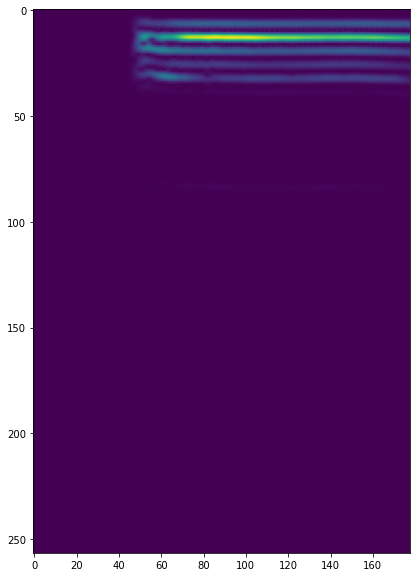

In [409]:
filepath, label = alfa.as_numpy_iterator().next()
filepath

spectrogram = preprocess(filepath, label)

plt.figure(figsize=(15,10))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

### 6.Create training and testing partitions

Here, the data, which is currently just individual string with a path to .wav file in, will be converted in to spectrograms for the CNN  to work with
#### 6.1 Create a Tensorflow data pipeline 


In [410]:
len(iota)

49

In [411]:
data = data.map(preprocess)
len(data)

113

In [412]:
# Let's 'macshbap' the data! 
data = data.map(preprocess)
data = data.cache()
# shuffle to mix up the traning samples as to not 
#have positives at the start and negatives at the end:
data = data.shuffle(buffer_size=1000)
# Batch it up to train at 16 samples at a time
data = data.batch(16)
# Prefetch 8 examples to eliminate potential cpu bottleneck
data = data.prefetch(8)
len(data)

8

In [413]:
len(data)

8

#### 6.2 Split into traning and test partitions

In [414]:
# Here, we check the length of our data
len(data)
# The length is 51, and we'll have 70% as our training data
len(data)*0.7
# 70% of the data is 35.69, let's round it up to 36

5.6

In [415]:
# Training data with 36 of the samples
train = data.take(5)
# Test data, here we skip the initial 36 and take the remaining 15
test = data.skip(5).take(3)

#### 6.3 Test one batch

In [416]:
samples, labels = train.as_numpy_iterator().next()


In [424]:
samples.shape

(16, 178, 257, 1)

In [418]:
type(samples)

numpy.ndarray

### 7. Build deep learning model

#### 7.1 Load Tensorflow dependencies

In [419]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

#### 7.2 Build sequential model, compile and view summary

In [425]:
# Define sequential model
model = Sequential()
# Add convolutional layers:
## See explanation around 46:00-48:00. Read up on convolutional layers 
model.add(Conv2D(16,(3,3), activation='relu', input_shape=(178, 257, 1)))
model.add(Conv2D(16,(3,3), activation='relu'))
## Flatten the layer into a single dimension:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [426]:
# Compile the model
model.compile('Adam', loss = 'BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [427]:
# Let's have a look at the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 176, 255, 16)      160       
                                                                 
 conv2d_9 (Conv2D)           (None, 174, 253, 16)      2320      
                                                                 
 flatten_4 (Flatten)         (None, 704352)            0         
                                                                 
 dense_8 (Dense)             (None, 128)               90157184  
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 90,159,793
Trainable params: 90,159,793
Non-trainable params: 0
_________________________________________________________________


#### 7.3 Fit model, view loss and KPI plots

Let's train the model

In [428]:
# specifying we want to train for 4 epochs (???)
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
5/5 [==============================] - 2s 372ms/step - loss: 1.9598 - recall_4: 0.5833 - precision_4: 0.4375 - val_loss: 0.9181 - val_recall_4: 1.0000 - val_precision_4: 0.4545
Epoch 2/4
5/5 [==============================] - 1s 295ms/step - loss: 0.8409 - recall_4: 1.0000 - precision_4: 0.4375 - val_loss: 0.6916 - val_recall_4: 1.0000 - val_precision_4: 0.5455
Epoch 3/4
5/5 [==============================] - 2s 321ms/step - loss: 0.6944 - recall_4: 0.1562 - precision_4: 0.3125 - val_loss: 0.6927 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00
Epoch 4/4
5/5 [==============================] - 1s 300ms/step - loss: 0.6810 - recall_4: 0.0000e+00 - precision_4: 0.0000e+00 - val_loss: 0.8318 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00


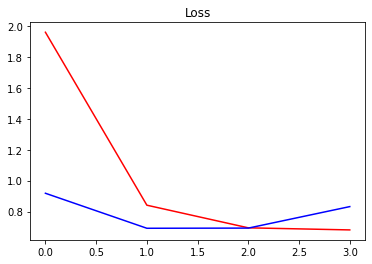

In [430]:
plt.title('Loss')
plt.plot(hist.history['loss'],'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

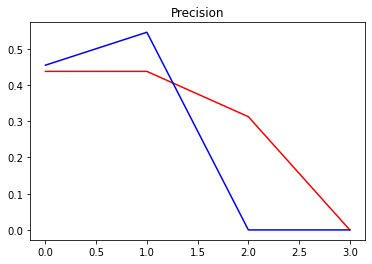

In [432]:
plt.title('Precision')
plt.plot(hist.history['precision_4'], 'r')
plt.plot(hist.history['val_precision_4'], 'b')
plt.show()

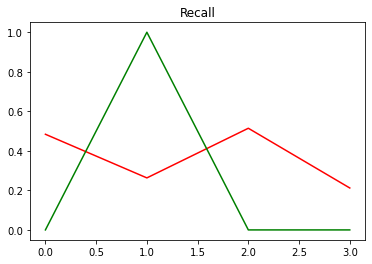

In [322]:
plt.title('Recall')
plt.plot(hist.history['recall_2'], 'r')
plt.plot(hist.history['val_recall_2'], 'g')
plt.show()

In [433]:
hist

In [434]:
hist.history

{'loss': [1.9597917795181274,
  0.8409002423286438,
  0.6944102048873901,
  0.6809757947921753],
 'recall_4': [0.5833333134651184, 1.0, 0.15625, 0.0],
 'precision_4': [0.4375, 0.4375, 0.3125, 0.0],
 'val_loss': [0.918110728263855,
  0.6916300058364868,
  0.6927379369735718,
  0.8318132162094116],
 'val_recall_4': [1.0, 1.0, 0.0, 0.0],
 'val_precision_4': [0.4545454680919647, 0.5454545617103577, 0.0, 0.0]}

In [435]:
hist.history['loss']

[1.9597917795181274,
 0.8409002423286438,
 0.6944102048873901,
 0.6809757947921753]

### 8. Make a prediction on a single clip

#### 8.1 Get one batch and make a prediction

In [436]:
X_test, Y_test = test.as_numpy_iterator().next()
X_test, Y_test

(array([[[[0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00],
          ...,
          [0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00]],
 
         [[0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00],
          ...,
          [0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00]],
 
         [[0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00],
          ...,
          [0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00]],
 
         ...,
 
         [[6.9549493e-03],
          [9.5476564e-03],
          [6.7906789e-03],
          ...,
          [4.9549294e-07],
          [8.5161810e-07],
          [1.0214280e-06]],
 
         [[1.9844603e-02],
          [4.5328066e-03],
          [1.3793848e-02],
          ...,
          [6.0347207e-07],
          [6.8702371e-07],
          [7.6275319e-07]],
 
         [[2.2282466e-02],
          [2.9318077e-02],
          [1.5597770e-02],
   

In [437]:
Y_test.shape

(16,)

In [438]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 88ms/step


In [439]:
yhat

array([[0.32829946],
       [0.32829946],
       [0.32829946],
       [0.32829946],
       [0.32829946],
       [0.32829946],
       [0.32829946],
       [0.32829946],
       [0.32829946],
       [0.32829946],
       [0.32829946],
       [0.32829946],
       [0.32829946],
       [0.32829946],
       [0.32829946],
       [0.32829946]], dtype=float32)

In [440]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [441]:
yhat

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [442]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [443]:
tf.math.reduce_sum(Y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

In [444]:
Y_test.astype(int)

array([1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0])